# Build noise models

This page shows how to use the Qiskit Aer [`noise`](https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html) module to build noise models for simulating quantum circuits in the presence of errors. This is useful for emulating noisy quantum processors and for studying the effects of noise on the execution of quantum algorithms.

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.tools.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

## Qiskit Aer `noise` module

The Qiskit Aer `noise` module contains Python classes to build customized noise models for simulation. There are three key classes:

1. The `NoiseModel` class which stores a noise model used for noisy simulation.
2. The `QuantumError` class which describes CPTP gate errors. These can be applied:
    * After *gate* or *reset* instructions
    * Before *measure* instructions.

3. The `ReadoutError` class which describes classical readout errors.

## Initializing a noise model from a backend

You can initialize a noise model with parameters set from the latest calibration data for a physical backend:

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

This will yield a noise model that roughly approximates the errors one would encounter when using that backend. If you want to have more detailed control over the parameters of the noise model, then you'll need to create your own noise model, as described in the rest of this page.

## Quantum Errors

Rather than deal with the `QuantumError` object directly, many helper functions exist to automatically generate a specific type of parameterized quantum error. These are contained in the `noise` module and include functions for many common errors types used in quantum computing research. The function names and the type of error they return are:

| Standard error function | Details |
| --- | --- |
| `kraus_error` | a general n-qubit CPTP error channel given as a list of Kraus matrices $[K_0, ...]$. |
| `mixed_unitary_error` | an n-qubit mixed unitary error given as a list of unitary matrices and probabilities $[(U_0, p_0),...]$. |
| `coherent_unitary_error` | an n-qubit coherent unitary error given as a single unitary matrix $U$. |
| `pauli_error` | an n-qubit Pauli error channel (mixed unitary) given as a list of Pauli's and probabilities $[(P_0, p_0),...]$ |
| `depolarizing_error` | an n-qubit depolarizing error channel parameterized by a depolarization probability $p$. |
| `reset_error` | a single-qubit reset error parameterized by a probabilities $p_0, p_1$ of resetting to the $|0\rangle$, $|1\rangle$ state.|
| `thermal_relaxation_error` | a single qubit thermal relaxation channel parameterized by relaxation time constants $T_1$, $T_2$, gate time $t$, and excited state thermal population $p_1$. |
| `phase_amplitude_damping_error` | A single-qubit generalized combined phase and amplitude damping error channel given by an amplitude damping parameter $\lambda$, a phase damping parameter $\gamma$, and an excited state thermal population $p_1$. |
| `amplitude_damping_error` |  A single-qubit generalized amplitude damping error channel given by an amplitude damping parameter $\lambda$, and an excited state thermal population $p_1$. |
| `phase_damping_error` |  A single-qubit phase damping error channel given by a phase damping parameter $\gamma$ |

### Combining quantum errors

`QuantumError` instances can be combined by using composition, tensor product, and tensor expansion (reversed order tensor product) to produce new `QuantumErrors` as:

 * Composition: $\cal{E}(\rho)=\cal{E_2}(\cal{E_1}(\rho))$ as `error = error1.compose(error2)`
 * Tensor product: $\cal{E}(\rho) =(\cal{E_1}\otimes\cal{E_2})(\rho)$ as `error error1.tensor(error2)`
 * Expand product: $\cal{E}(\rho) =(\cal{E_2}\otimes\cal{E_1})(\rho)$ as `error error1.expand(error2)`

### Example

For example to construct a 5% single-qubit Bit-flip error:

In [3]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [4]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [5]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


### Converting to and from QuantumChannel operators

We can also convert back and forth between `QuantumError` objects in Qiskit Aer and `QuantumChannel` objects in Qiskit Terra.

In [6]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [-1.20234617e-16+0.j,  9.74679434e-01+0.j]],

       [[ 2.62045272e-16+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -2.84112242e-16+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [7]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [8]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))

# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

### Readout Error

Classical readout errors are specified by a list of assignment probabilities vectors $P(A|B)$:

  * $A$ is the *recorded* classical bit value
  * $B$ is the *true* bit value returned from the measurement

E.g. for 1 qubits: $ P(A|B) = [P(A|0), P(A|1)]$.

In [9]:
# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

Readout errors may also be combined using `compose`, `tensor` and `expand` like with quantum errors.

## Adding errors to a Noise Model

When adding a quantum error to a noise model we must specify the type of *instruction* that it acts on, and what qubits to apply it to. There are two cases for Quantum Errors:

 1. All-qubit quantum error
 2. Specific qubit quantum error

### 1. All-qubit quantum error

This applies the same error to any occurrence of an instruction, regardless of which qubits it acts on.

It is added as `noise_model.add_all_qubit_quantum_error(error, instructions)`:

In [10]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


### 2. Specific qubit quantum error

This applies the error to any occurrence of an instruction acting on a specified list of qubits. Note that the order of the qubit matters: For a 2-qubit gate an error applied to qubits [0, 1] is different to one applied to qubits [1, 0] for example.

It is added as `noise_model.add_quantum_error(error, instructions, qubits)`:

In [11]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


### Note on non-local qubit quantum error

`NoiseModel` does not support addition of non-local qubit quantum errors. They should be handled outside of `NoiseModel`. That suggests you should [write your own transpiler pass](/transpile/custom-transpiler-pass) (`TransformationPass`) and run the pass just before running the simulator if you need to insert your quantum errors into your circuit under your own conditions.

### Executing a noisy simulation with a noise model

The command `AerSimulator(noise_model=noise_model)` returns a simulator configured to the given noise model. In addition to setting the simulator's noise model, it also overrides the simulator's basis gates, according to the gates of the noise model.

## Noise Model Examples

We will now give some examples of noise models. For our demonstrations we will use a simple test circuit generating a n-qubit GHZ state:

In [12]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


### Ideal Simulation

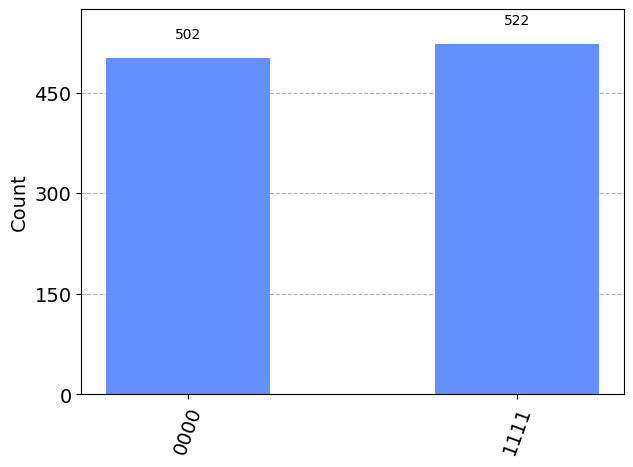

In [13]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

## Noise Example 1: Basic bit-flip error noise model

Lets consider a simple toy noise model example common in quantum information theory research:

* When applying a single qubit gate, flip the state of the qubit with probability `p_gate1`.
* When applying a 2-qubit gate apply single-qubit errors to each qubit.
* When resetting a qubit reset to 1 instead of 0 with probability `p_reset`.
* When measuring a qubit, flip the state of the qubit with probability `p_meas`.

In [14]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'reset', 'measure', 'cx', 'u1', 'u2']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Executing the noisy simulation

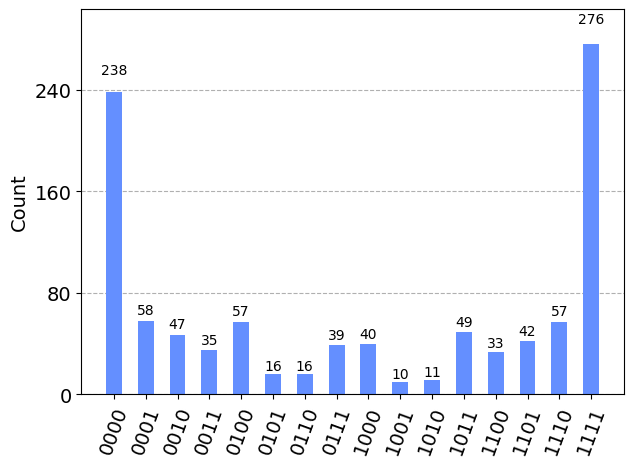

In [15]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
circ_tnoise = passmanager.run(circ)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

## Example 2: T1/T2 thermal relaxation

Now consider a more realistic error model based on thermal relaxation with the qubit environment:
* Each qubit is parameterized by a thermal relaxation time constant $T_1$ and a dephasing time constant $T_2$.
* Note that we must have $T_2 \le 2 T_1$.
* Error rates on instructions are determined by gate times and qubit $T_1$, $T_2$ values.

In [16]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u3', 'reset', 'measure', 'cx', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


### Executing the noisy simulation

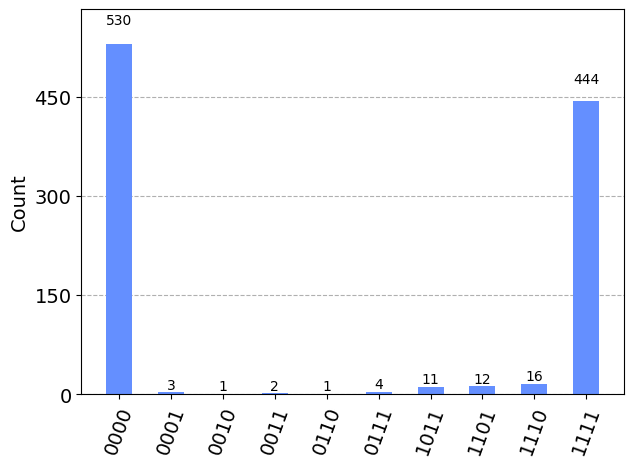

In [17]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_thermal)
circ_tthermal = passmanager.run(circ)

# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Plot noisy output
plot_histogram(counts_thermal)

## Next steps

<Admonition type="tip" title="Recommendations">
  - To simulate noisy circuits, see [Exact and noisy simulation with Qiskit Aer primitives](simulate-with-qiskit-primitives).
  - Review the [Qiskit Aer noise module](https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html) reference.
</Admonition>